In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    return SVG(
        model_to_dot(
            model,
            show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

Using TensorFlow backend.


In [5]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from kerashistoryplot.callbacks import PlotHistory

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [6]:
from sklearn.model_selection import train_test_split

In [105]:
def make_data(num=1000, sort=True):
    x = np.linspace(0, 1, num=num)
    scale = x
    mean = 4 * x * ( 1 - x )
    y = mean + np.random.exponential(scale=scale, size=x.size)
    return x.reshape(-1, 1), y

X_train, y_train = make_data(num=10000)
X_test, y_test = make_data(num=10000)

X_plot = np.linspace(min(X_train), max(X_train), num=200).reshape(-1, 1)

In [299]:
quantiles = [0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999]
q_theor = np.hstack([
    -np.log(1 - q) * X_test + 4 * X_test * ( 1 - X_test )
    for q in quantiles
])

(0, 5)

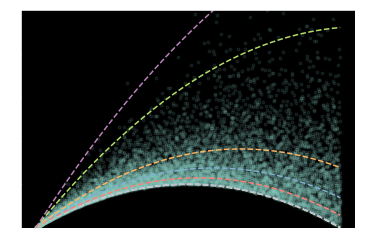

In [300]:
plt.plot(X_train, y_train, '.', alpha=0.1)
for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'q={q}')
plt.ylim(0, 5)

In [301]:
import deepquantiles

from deepquantiles.losses import sk_quantile_loss

In [302]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=15),
    PlotHistory(batches=False, n_cols=3, figsize=(15, 7))
]

# Multi-Quantile Regression

In [303]:
regressor = deepquantiles.MultiQuantileRegressor(
    shared_units=(32, 32, 32),
    quantile_units=(64, ),
    quantiles=quantiles,
    lr=0.01,
    epochs=100,
    batch_size=1000
)

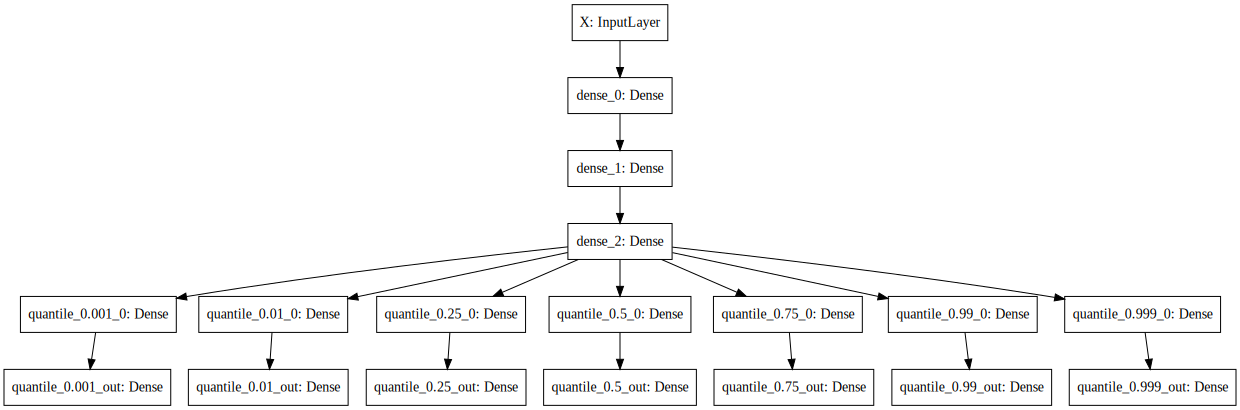

In [304]:
vis_model(regressor.model, show_shapes=False)

In [305]:
regressor.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
dense_0 (Dense)                 (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense_0[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
__________________________________________________________________________________________________
quantile_0

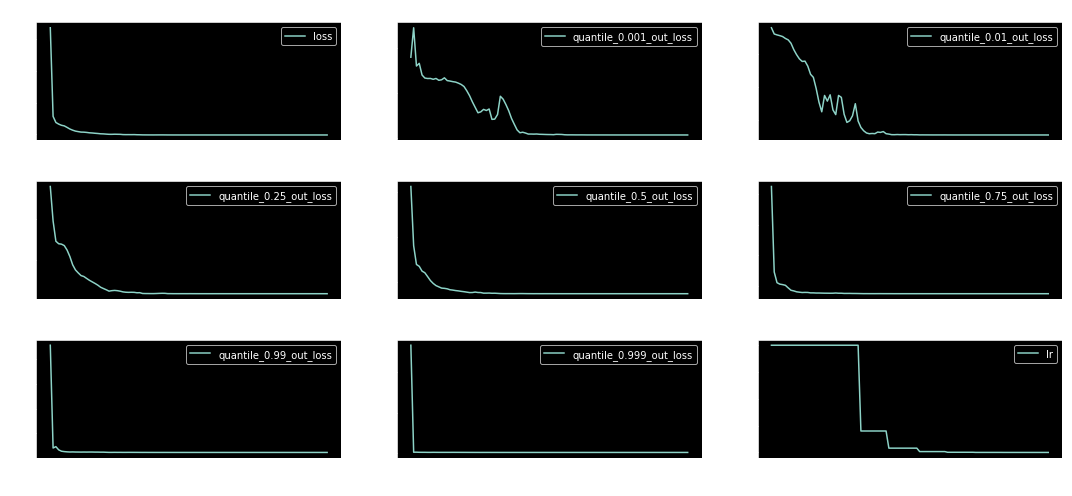

CPU times: user 4min 38s, sys: 33 s, total: 5min 11s
Wall time: 2min 34s


In [306]:
%%time
regressor.fit(X_train, y_train, verbose=1, callbacks=callbacks, shuffle=True)

In [307]:
q_preds = regressor.predict(X_test)

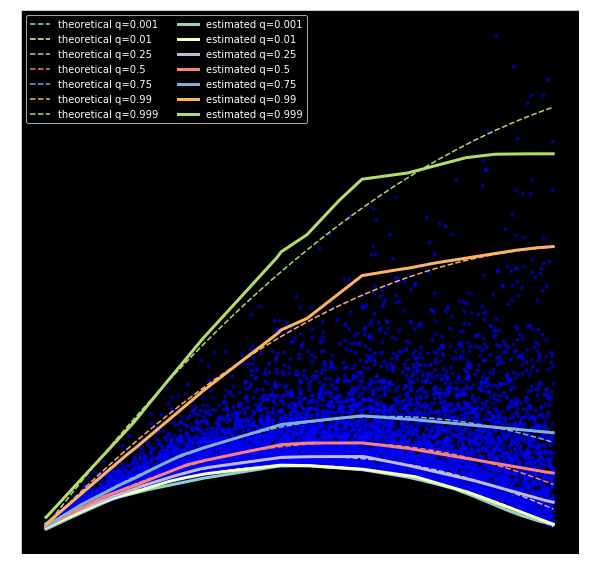

In [308]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

In [309]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 1.13 ms, sys: 651 µs, total: 1.79 ms
Wall time: 1.07 ms


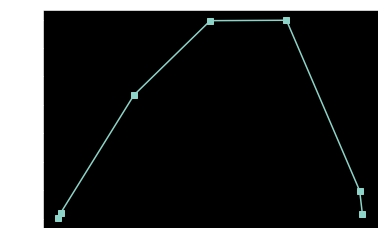

In [310]:
plt.plot(regressor.quantiles, scores, 's-')

## Regress on Quantile `q`

In [341]:
regressor = deepquantiles.CDFRegressor(
    hidden_units=(128, 128, 128, 128),
    activation='relu',
    lr=0.01,
    epochs=100,
    batch_size=1000,
    q_mode='point',
    shuffle_points=True
)

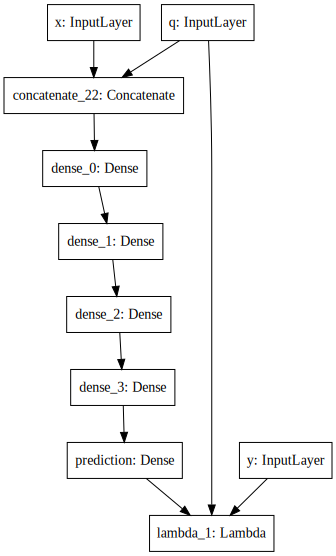

In [342]:
vis_model(regressor.model['loss'])

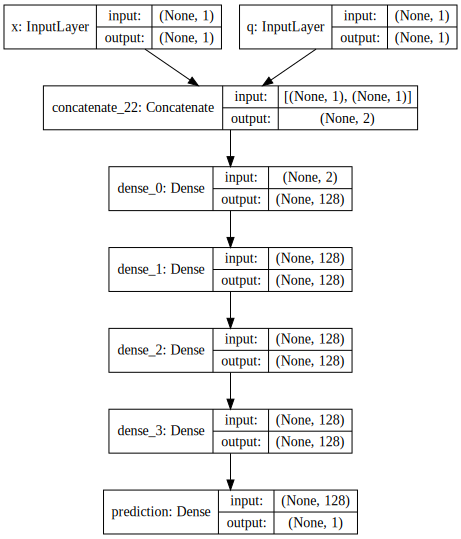

In [343]:
vis_model(regressor.model['quantile'], show_shapes=True)

In [344]:
regressor.model['quantile'].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
q (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 2)            0           x[0][0]                          
                                                                 q[0][0]                          
__________________________________________________________________________________________________
dense_0 (Dense)                 (None, 128)          384         concatenate_22[0][0]             
__________

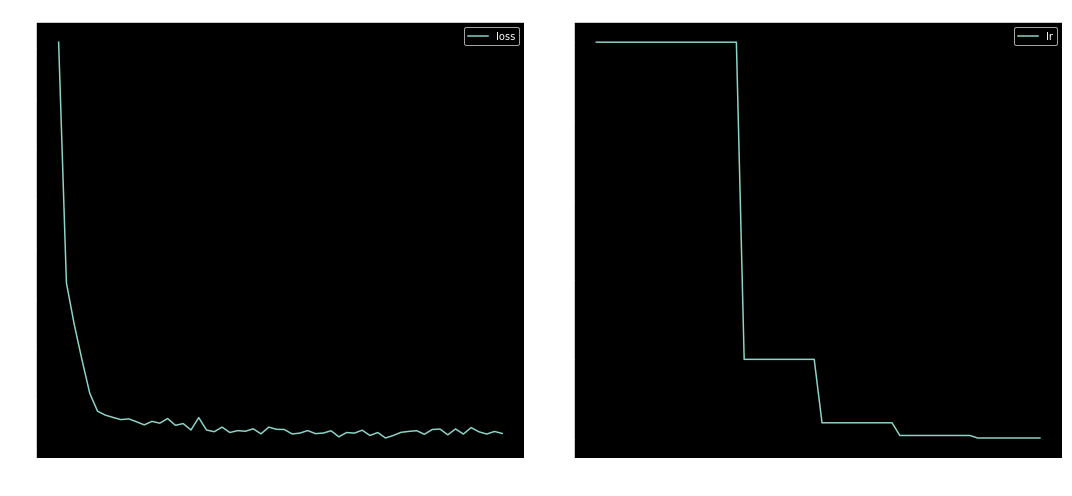

CPU times: user 1min 15s, sys: 11.6 s, total: 1min 27s
Wall time: 38.6 s


In [345]:
%%time
regressor.fit(X_train, y_train, verbose=1, callbacks=callbacks)

In [346]:
q_preds = regressor.predict(X_test, quantiles=quantiles)

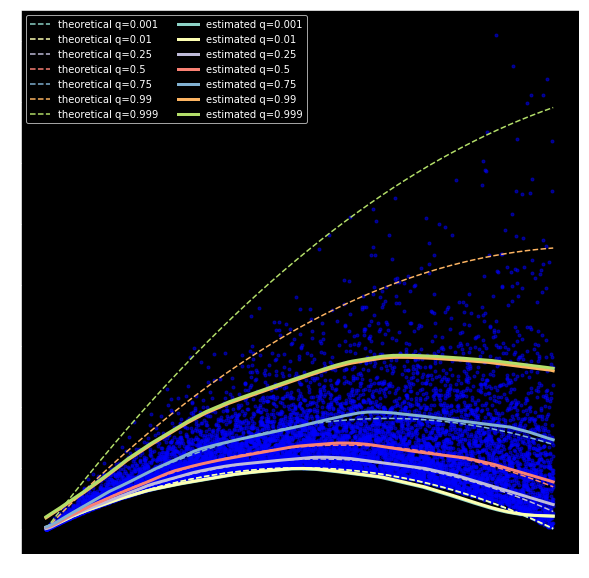

In [347]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

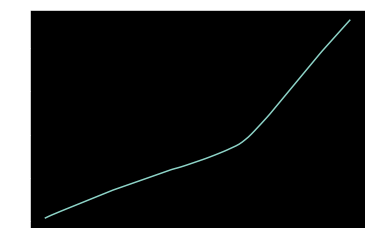

In [348]:
num = 100
qs = np.linspace(0, 1, num=num)
preds = regressor.model['quantile'].predict([0.8 + 0 * qs, qs])
plt.plot(qs, preds)

In [349]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 1.1 ms, sys: 581 µs, total: 1.68 ms
Wall time: 1.14 ms


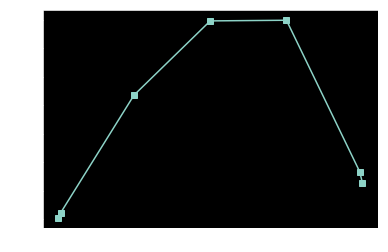

In [350]:
plt.plot(quantiles, scores, 's-')

## Gradient Boosting QR

In [320]:
from sklearn.ensemble import GradientBoostingRegressor

In [321]:
gbr = GradientBoostingRegressor(
    loss='quantile',
#     alpha=0.5,
     n_estimators=250,
     max_depth=1,
     learning_rate=.1,
)

In [322]:
%%time
quantiles = quantiles
q_preds = []
scores = []
for q in quantiles:
    gbr.set_params(alpha=q)
    gbr.fit(X_train, y_train)
    q_pred = gbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

CPU times: user 3.08 s, sys: 15 ms, total: 3.09 s
Wall time: 3.11 s


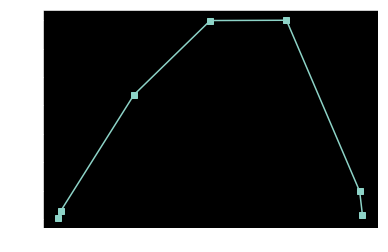

In [323]:
plt.plot(quantiles, scores, 's-')

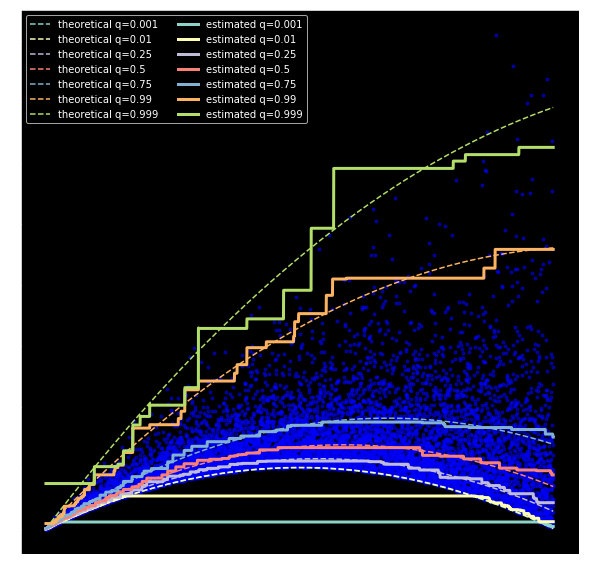

In [324]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

## CatBoost

In [250]:
from catboost import CatBoostRegressor
from tqdm.autonotebook import tqdm

In [251]:
cbr = CatBoostRegressor(verbose=0)

In [252]:
quantiles = quantiles
q_preds = []
scores = []
for q in tqdm(quantiles):
    cbr.set_params(loss_function=f'Quantile:alpha={q}')
    cbr.fit(X_train, y_train)
    q_pred = cbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

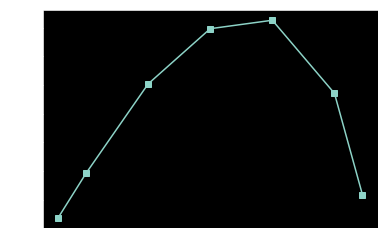

In [253]:
plt.plot(quantiles, scores, 's-')

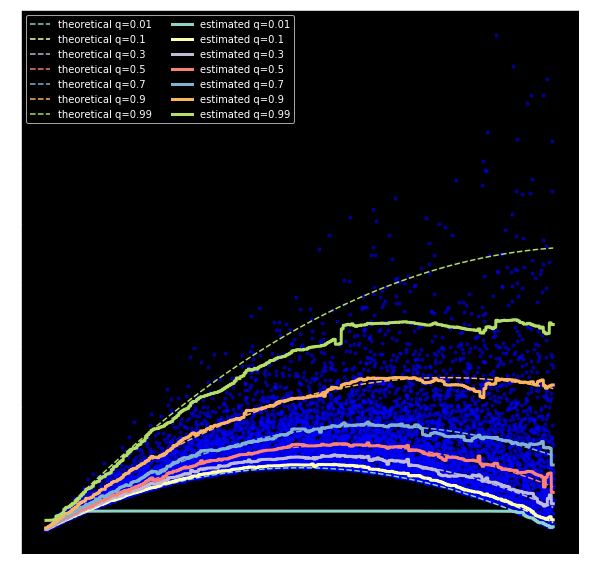

In [256]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)